## MEAM 5460 HW3
### Author: Nathaniel Ruhl

### 1) Introduction

In order to predict the performance of a rotor, it is necessary to calculate the inflow induced by the rotor, $\lambda=v_i/\Omega R$ where $v_i$ is the induced velocity at the rotor plane, $\Omega$ is angular velocity of the rotor blades, and $R$ is the rotor radius. Blade element momentum theory (BEMT) is a powerfule tool to predict the inflow and the performance measures of a rotor in hover, such as the coefficients of thrust and power, $C_T$ and $C_P$. Moreover, BEMT is versatile enough to account for variations in blade chord, twist, and taper, and it can also make use of a tip loss model, thus providing an extremely useful and realistic tool to compare and analyze different rotor designs. 

In this report, I present a tool that I have made using BEMT to calculate the induced inflow ratio $\lambda$, distributions of local coefficients of thrust and power $c_T$ and $c_P$, as well as their total counterparts $C_T$ and $C_P$. I report only the __induced__ velocity and power coefficients, which do not include effects of profile drag (although I do not explicitly use the $i$ subscript). The script "hw3_BEMT.py" contains the functions to perform BEMT analysis and the code in this notebook demonstrates how to use the tool. In this version of the BEMT tool, I make a couple simplifying assumptions which are listed below.

1. The rotor is in hover: $\lambda_c=0$
2. The rotor has an ideal twist distibution specified by the input collective at 75%R: $\theta(r)=0.75\theta_{75}/r$
3. Constant blade chord (no taper variation)
4. Linear thin airfoil assumption: $c_{l,\alpha}=2\pi$ lift-curve slope
5. Tip losses are ignored

In the next Project 1 assignment, I will break assumptions 2-5.

### 2) The "Rotor" class and baseline test rotor specifications

The analysis below is performed on a rotor blade with the folowing specifications ($R$ and $c$ are similar to a rotor of the chinook):

- $N_b = 3$  # number of blades
- $c = 2.0$ # Chord length, ft
- $v_{tip} = 650$ # ft/sec
- $R = 30$ # ft
- $\sigma = N_b c/\pi R = 0.0636$  # solidity
- $c_{l,\alpha} = 2 \pi$ # Lift-curve slope

The variables listed above are the default instance variables for a 'Rotor' object. After a rotor object is defined via `rotor = Rotor()`, you can change the properties via `rotor.c=3`, etc... Note that we wish to analyze our rotor at the MSL density of 0.002378 slug/ft^3, but this number does not come into play when strictly using the non-dimensional coefficients.

### 3) BEMT Equations

BEMT predicts the local coefficiecients of thrust and power to be

$$c_T(r) = 4\lambda^2(r) r$$
$$c_P(r) = 4\lambda^3(r) r$$

where 
$$\lambda(r) = \frac{\sigma c_{l,\alpha}}{16} \left( \sqrt{1+\frac{32}{\sigma c_{l,\alpha}} \theta(r) r} - 1 \right)$$ and the rotor solidity is $\sigma=\frac{N_b c}{\pi R}$.

The local coefficients are also known as thrust and power "gradients": $c_T=dC_T/dr$ and $c_P=dC_P/dr$.

As stated previously, in this report, we make the simplifying assumptions that

$$\theta(r)=0.75 \theta_{75}/r, \quad c_{l,\alpha}=2 \pi .$$

In this case, BEMT predicts that $\lambda$ is independent of $r$:

$$\lambda = \frac{\sigma c_{l,\alpha}}{16} \left( \sqrt{1+\frac{32}{\sigma c_{l,\alpha}} 0.75 \theta_{75}} - 1 \right)$$

Therefore, the local and total coefficients of thrust and power can be written as:

$$c_T(r) = 4\lambda^2 r$$
$$c_P(r) = 4\lambda^3 r$$
$$C_T = 4 \lambda^2 \int_0^1 r dr = 2 \lambda^2 $$
$$C_P = 4 \lambda^3 \int_0^1 r dr = 2 \lambda^3. $$

In order to prepare for Project 1 where we remove some of our assumptions, I implemented gaussian quadrature to evaluate the numerical integrals. Lastly, we can write the local angle of attack of an airfoil as

$$\alpha(r) = \theta(r) - \phi(r)$$

where $\phi(r)$ is the induced inflow angle. In hover, the inflow angle can be written as:

$$\phi(r) = \frac{\lambda}{r}$$.

For completeeness, recall the equation for the local airfoil coefficient of lift under linear aerodynamics:

$$c_{l}(r)=c_{l,\alpha} \alpha(r)$$

#### 3a) Comparison to Momentum Theory

In order to validate our results, we will compare the BEMT to blade-less rotor-disk momentum theory. In this theory, the induced inflow in hower is equal to $\lambda_h = \sqrt{C_T/2}$, where we will use the value of $C_T$ from BEMT in order to evaluate $\lambda_h$.

### 4) Analysis

This analysis makes use of the modules, classes, and functions imported in the cell block below. It should be noted that I often used upper case greek letters as function definitions, and I also use the notation $c_T(r)=$ `dCT(r)` and $c_P(r)=$ `dCP(r)` in the code. The functions also take inputs of a "Rotor" object, and you can write `Theta?` in a code cell to see information about the $\theta(r)$ function.

Lastly, the two codebloacks below are all that is needed to use this tool. The "rotor" object can be changed dynamically as the user desires (although it is always good to confirm that you are correctly changing the rotor object in the Kernel memory, and re-run the `importlib.reload()` lines if changes are made to the scripts).

In [21]:
# import standard libraries
import importlib
import numpy as np
import matplotlib.pyplot as plt

# import local modules (these scripts must be in the working directory)
import Rotor
importlib.reload(Rotor)
from Rotor import Rotor  # Rotor class definition
import hw3_BEMT   # BEMT tool
importlib.reload(hw3_BEMT)
from hw3_BEMT import Theta, Lambda, Alpha, Phi, dCT, dCP, calc_CT_CP

In [22]:
rotor = Rotor()
# Here is where you can change rotor properties with rotor.c=3, rotor.Nb=4, etc...

The plot below shows the ideal twist distribution of a rotor with $\theta_{75}=5^\circ$

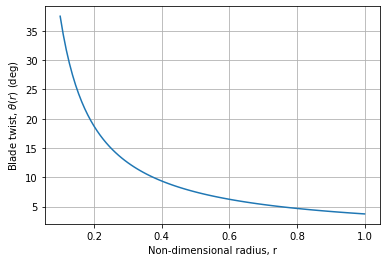

In [23]:
rs = np.linspace(0.1, 1, 100)  # Non-dimensional blade radius
theta_75 = np.deg2rad(5)       # Blade twist at 75%R

plt.plot(rs, np.rad2deg(Theta(rs, theta_75)))
plt.ylabel(r"Blade twist, $\theta(r)$ (deg)")
plt.xlabel("Non-dimensional radius, r")
plt.grid()

#### Performance Profiles

Let's first consider the profiles of $\lambda$, $c_T$, and $c_P$ as a function of non-dimensional radius. The plots below the expected relationships when the blade has ideal twist: uniform inflow $\lambda$, as well as linearly increasing $c_T(r)$ and $c_P(r)$. For the profiles in the first group of plots below, I will consider $\theta_{75}=5^\circ$. The plot for $\lambda$ below shows the comparison to momentum theory in the legend, where $\lambda_h=\sqrt{C_T/2}$, and thus the $C_T$ calculated by BEMT is consistent with momentum theory. Furthermore, since the values of $C_T$ and $C_P$ predicted by momentum theory are explicitly related to $\lambda_h$, we see the same constitencty for $C_T$ and $C_P$ between simple momentum theory and BEMT. The legend of the thrust and power profiles shows the total $C_T$ and $C_P$ (area under the $c_T$ and $c_P$ curves).

(0.0, 15.0)

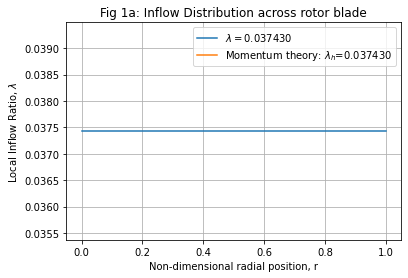

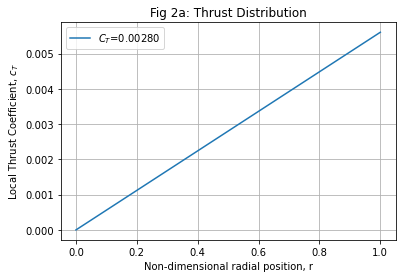

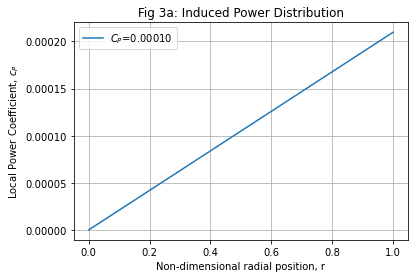

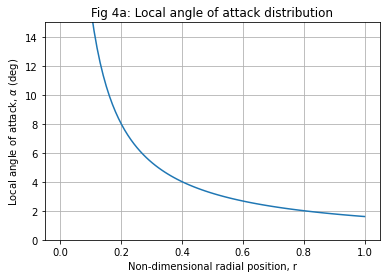

In [33]:
# Code for plotting lmbda, c_T, and c_P profiles

theta_75 = np.deg2rad(5)

CT, CP = calc_CT_CP(theta_75, rotor)   
# I originally wrote the above function to do numerical integration, but replaced it with the closed form solution

plt.figure(1)
plt.title("Fig 1a: Inflow Distribution across rotor blade")
plt.plot(rs, Lambda(rs, theta_75, rotor),label=f"$\lambda={Lambda(1, theta_75, rotor):.6f}$")
plt.plot([],[],label=rf"Momentum theory: $\lambda_h$={np.sqrt(CT/2):.6f}")
plt.grid()
plt.xlabel("Non-dimensional radial position, r")
plt.ylabel(r"Local Inflow Ratio, $\lambda$")
plt.legend()

plt.figure(2)
plt.title("Fig 2a: Thrust Distribution")
plt.plot(rs, dCT(rs, theta_75, rotor), label=fr'$C_T$={CT:.5f}')
plt.grid()
plt.xlabel("Non-dimensional radial position, r")
plt.ylabel("Local Thrust Coefficient, $c_T$")
plt.legend()

plt.figure(3)
plt.title("Fig 3a: Induced Power Distribution")
plt.plot(rs, dCP(rs, theta_75, rotor), label=fr'$C_P$={CP:.5f}')
plt.grid()
plt.xlabel("Non-dimensional radial position, r")
plt.ylabel("Local Power Coefficient, $c_P$")
plt.legend()

plt.figure(4)
plt.title("Fig 4a: Local angle of attack distribution")
plt.plot(rs, np.rad2deg(Alpha(rs, theta_75, rotor)))
plt.grid()
plt.xlabel("Non-dimensional radial position, r")
plt.ylabel(r"Local angle of attack, $\alpha$ (deg)")
plt.ylim([0,15])

Below, I will plot the profiles at three different input collectives, $\theta_{75}$

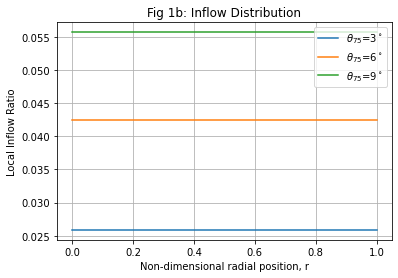

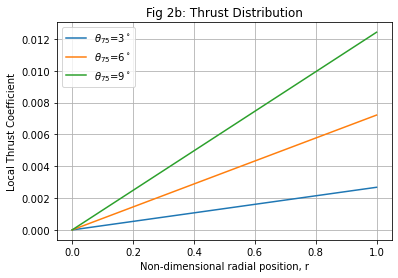

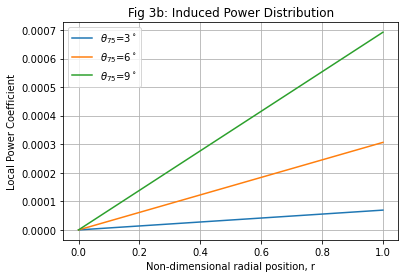

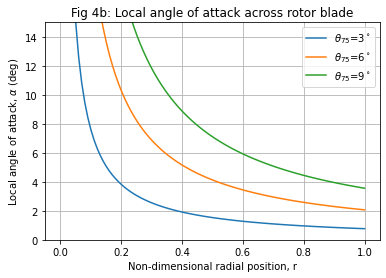

In [29]:
theta_75_list_deg = np.array([3,6,9])
theta_75_list_rad = np.deg2rad(theta_75_list_deg)

for i, theta_75 in enumerate(theta_75_list_rad):

    CT, CP = calc_CT_CP(theta_75, rotor)

    rs = np.linspace(0.0001, 1, 100)  # Non-dimensional blade radius

    plt.figure(1)
    plt.plot(rs, Lambda(rs, theta_75, rotor),label=fr"$\theta_{{75}}$={theta_75_list_deg[i]:.0f}$^\circ$")

    plt.figure(2)
    plt.plot(rs, dCT(rs, theta_75, rotor), label=fr"$\theta_{{75}}$={theta_75_list_deg[i]:.0f}$^\circ$")

    plt.figure(3)
    plt.plot(rs, dCP(rs, theta_75, rotor), label=fr"$\theta_{{75}}$={theta_75_list_deg[i]:.0f}$^\circ$")

    plt.figure(4)
    plt.plot(rs, np.rad2deg(Alpha(rs, theta_75, rotor)), label=fr"$\theta_{{75}}$={theta_75_list_deg[i]:.0f}$^\circ$")
    
plt.figure(1)
plt.title("Fig 1b: Inflow Distribution")
plt.grid()
plt.xlabel("Non-dimensional radial position, r")
plt.ylabel("Local Inflow Ratio")
plt.legend()

plt.figure(2)
plt.title("Fig 2b: Thrust Distribution")
plt.grid()
plt.xlabel("Non-dimensional radial position, r")
plt.ylabel("Local Thrust Coefficient")
plt.legend()

plt.figure(3)
plt.title("Fig 3b: Induced Power Distribution")
plt.grid()
plt.xlabel("Non-dimensional radial position, r")
plt.ylabel("Local Power Coefficient")
plt.legend()

plt.figure(4)
plt.title("Fig 4b: Local angle of attack across rotor blade")
plt.grid()
plt.xlabel("Non-dimensional radial position, r")
plt.ylabel(r"Local angle of attack, $\alpha$ (deg)")
plt.ylim([0,15])
plt.legend()

#### Performance as a Function of Input Collective

The next step of the analysis is to calculate the total performance coefficients $C_T$ and $C_P$ as a function of input collective $\theta_{75}$. In order to better understand these plots, I wanted to approximate the maximum value for input collective, which I indicate with a red dashed line in the plots below. For the ideal twist distribution (with uniform inflow), the local airfoils on the rotor blade near the hub have the largest angles of attack, and are at risk of stalling (figure 4 above) when the input collective $\theta_{75}$ is too large. For this reason, I identified the approximate $\theta_{75}$ at which the local AoA at $r_{hub}=0.12$ is greater than $15^\circ$. Therefore, to the right of the red dashed lines in each plots below, there is a risk of stall at the base of the rotor blades. This also helps us better determine the maximum blade performance, especially since the performance coefficients will increase monotonically with input collective, as we will see.

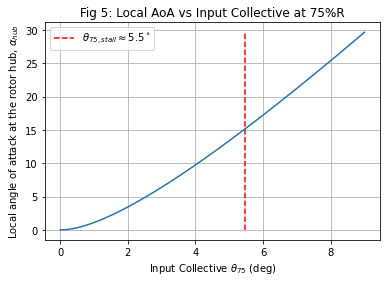

In [34]:
# Code for plotting Performance as a function of input collective
r_hub = 0.12  # non-dimensional radius of the hub
N_thetas = 200
theta75_deg = np.linspace(0,9,N_thetas)
theta75_rad = np.deg2rad(theta75_deg)

CT_list = np.zeros(N_thetas)
CP_list = np.zeros(N_thetas)
lambda_list = np.zeros(N_thetas)
alpha_hub_list = np.zeros(N_thetas)

for i in range(N_thetas):
    lambda_list[i] = Lambda(1, theta75_rad[i], rotor)  # note: r=1 is arbitray since lambda=const(r) for ideal twist
    CT_list[i], CP_list[i] = calc_CT_CP(theta75_rad[i], rotor)
    alpha_hub_list[i] = np.rad2deg(Alpha(r_hub, theta75_rad[i], rotor))

# Determine approximate index of stall: where AoA > 15 deg at r_hub
stall_indx = np.where(alpha_hub_list>15)[0][0]
theta75_stall = theta75_deg[stall_indx]

plt.figure(5)
plt.title('Fig 5: Local AoA vs Input Collective at 75%R')
plt.plot(theta75_deg, alpha_hub_list)
plt.vlines(x=theta75_stall, ymin=min(alpha_hub_list), ymax=max(alpha_hub_list), color='r', linestyle='--',label=rf"$\theta_{{75,stall}} \approx${theta75_stall:.1f}$^\circ$")
plt.xlabel(r"Input Collective $\theta_{75}$ (deg)")
plt.ylabel(r"Local angle of attack at the rotor hub, $\alpha_{hub}$")
plt.grid()
plt.legend()

The plots below show $\lambda$, $C_T$, and $C_P$, each as a function of $\theta_{75}$.

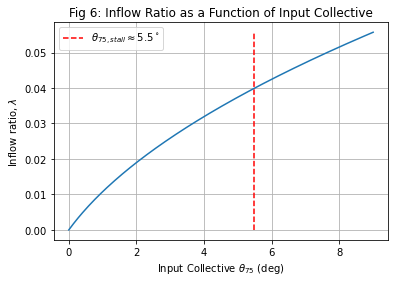

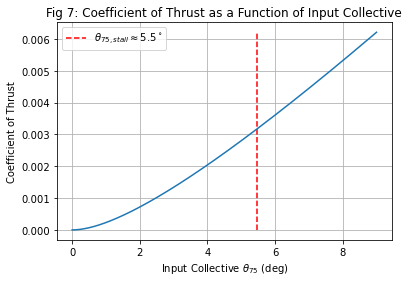

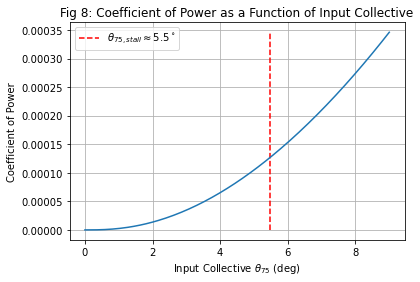

In [36]:
plt.figure(6)
plt.title("Fig 6: Inflow Ratio as a Function of Input Collective")
plt.plot(theta75_deg, lambda_list)
plt.vlines(x=theta75_stall, ymin=min(lambda_list), ymax=max(lambda_list), color='r', linestyle='--', label=rf"$\theta_{{75,stall}} \approx${theta75_stall:.1f}$^\circ$")
plt.xlabel(r"Input Collective $\theta_{75}$ (deg)")
plt.ylabel(r"Inflow ratio, $\lambda$")
plt.grid()
plt.legend()

plt.figure(7)
plt.title("Fig 7: Coefficient of Thrust as a Function of Input Collective")
plt.plot(theta75_deg, CT_list)
plt.vlines(x=theta75_stall, ymin=min(CT_list), ymax=max(CT_list), color='r', linestyle='--', label=rf"$\theta_{{75,stall}} \approx${theta75_stall:.1f}$^\circ$")
plt.xlabel(r"Input Collective $\theta_{75}$ (deg)")
plt.ylabel("Coefficient of Thrust")
plt.grid()
plt.legend()

plt.figure(8)
plt.title("Fig 8: Coefficient of Power as a Function of Input Collective")
plt.plot(theta75_deg, CP_list)
plt.vlines(x=theta75_stall, ymin=min(CP_list), ymax=max(CP_list), color='r', linestyle='--', label=rf"$\theta_{{75,stall}} \approx${theta75_stall:.1f}$^\circ$")
plt.xlabel(r"Input Collective $\theta_{75}$ (deg)")
plt.ylabel("Coefficient of Power")
plt.grid()
plt.legend()